## Imports

In [1]:
import cv2 as cv
import json
import matplotlib
import matplotlib.pyplot as plt
import glob
import pandas as pd
import random
import numpy as np

from torchvision.transforms import v2
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

#Ignore user warnings
import warnings
warnings.filterwarnings("ignore")

## Checking Annotations

In [2]:
# Read a JSON file
with open('data/Annotations/train.json') as f:
    trainJSON = json.load(f)

with open('data/Annotations/val.json') as f:
    valJSON = json.load(f)

with open('data/Annotations/test.json') as f:
    testJSON = json.load(f)

In [3]:
classes = trainJSON['categories']

train_images = trainJSON['images']
val_images = valJSON['images']
test_images = testJSON['images']

train_annotations = trainJSON['annotations']
val_annotations = valJSON['annotations']
test_annotations = testJSON['annotations']

In [4]:
print('========= Classes =========')
display(classes)
print('========= Train images =========')
display(train_images[:2])
print('========= Train nnotations =========')
display(train_annotations[:2])

========= Classes =========


[{'id': 1, 'name': 'LE;ER', 'supercategory': None},
 {'id': 4, 'name': 'SF;PO', 'supercategory': None},
 {'id': 0, 'name': 'VG;MT', 'supercategory': None},
 {'id': 2, 'name': 'LR;DA', 'supercategory': None},
 {'id': 3, 'name': 'LE;CR', 'supercategory': None}]

========= Train images =========


[{'id': 0,
  'folder': '/content/drive/MyDrive/AVALON/DTU-S2-and-S3/DTU-S3/S3-HR-train70-test15-val15-split/HR-dataset-split/Data-preparation/train-data/1024-s/train-images/',
  'file_name': 'DJI_0058_1_3.JPG',
  'path': None,
  'width': 1024,
  'height': 1024,
  'depth': 3},
 {'id': 1,
  'folder': '/content/drive/MyDrive/AVALON/DTU-S2-and-S3/DTU-S3/S3-HR-train70-test15-val15-split/HR-dataset-split/Data-preparation/train-data/1024-s/train-images/',
  'file_name': 'DJI_0013_0_3.JPG',
  'path': None,
  'width': 1024,
  'height': 1024,
  'depth': 3}]

========= Train nnotations =========


[{'image_id': 0,
  'id': 0,
  'segmented': None,
  'bbox': [383.996928, 424.001024, 99.00032, 90.000384],
  'area': 8910.0668161229,
  'segmentation': None,
  'iscrowd': 0,
  'pose': None,
  'truncated': None,
  'category_id': 1,
  'difficult': None},
 {'image_id': 0,
  'id': 1,
  'segmented': None,
  'bbox': [616.001024, 20.00128, 45.999104, 47.000576],
  'area': 2161.9843834839,
  'segmentation': None,
  'iscrowd': 0,
  'pose': None,
  'truncated': None,
  'category_id': 4,
  'difficult': None}]

In [5]:
train_images_names = []
val_images_names = []
test_images_names = []

for metadata in train_images:
    img_name = metadata['file_name'][:8] + metadata['file_name'][-4:]
    train_images_names.append(img_name)

for metadata in val_images:
    img_name = metadata['file_name'][:8] + metadata['file_name'][-4:]
    val_images_names.append(img_name)

for metadata in test_images:
    img_name = metadata['file_name'][:8] + metadata['file_name'][-4:]
    test_images_names.append(img_name)

# Drop duplicates from the lists
train_images_names = list(set(train_images_names))
val_images_names = list(set(val_images_names))
test_images_names = list(set(test_images_names))

In [6]:
print('========= Train images names =========')
display(train_images_names[:11])
print('========= Validation images names =========')
display(val_images_names[:11])
print('========= Test images names =========')
display(test_images_names[:11])

========= Train images names =========


['DJI_0702.JPG',
 'DJI_0129.JPG',
 'DJI_0440.JPG',
 'DJI_0009.JPG',
 'DJI_0382.JPG',
 'DJI_0209.JPG',
 'DJI_0044.JPG',
 'DJI_0200.JPG',
 'DJI_0625.JPG',
 'DJI_0243.JPG',
 'DJI_0448.JPG']

========= Validation images names =========


['DJI_0158.JPG',
 'DJI_0430.JPG',
 'DJI_0117.JPG',
 'DJI_0238.JPG',
 'DJI_0627.JPG',
 'DJI_0711.JPG',
 'DJI_0106.JPG',
 'DJI_0976.JPG',
 'DJI_0331.JPG',
 'DJI_0115.JPG',
 'DJI_0113.JPG']

========= Test images names =========


['DJI_0182.JPG',
 'DJI_0687.JPG',
 'DJI_0706.JPG',
 'DJI_0053.JPG',
 'DJI_0091.JPG',
 'DJI_0703.JPG',
 'DJI_0206.JPG',
 'DJI_0055.JPG',
 'DJI_0616.JPG',
 'DJI_0395.JPG',
 'DJI_0624.JPG']

## Data Preparation

In [7]:
class NordtankDataset(torch.utils.data.Dataset):
    def __init__(self, images_names, transform = None):
        self.images_names = images_names
        self.transform = transform

    def __len__(self):
        return len(self.images_names)

    def __getitem__(self, idx):
        img_name = self.images_names[idx]
        img_path = img_name
        image = cv.imread(img_path)
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        image = torch.from_numpy(image.transpose(2, 0, 1))

        if self.transform:
            image = self.transform(image)
    
        image = image.permute(1, 2, 0)

        return image


# Divide test_image into several images with 1024x1024 pixels excluding the sub-images that are not 1024x1024 pixels
def DivideImage(image, size):
    sub_images = []
    h, w, c = image.shape
    for i in range(0, h, size):
        for j in range(0, w, size):
            sub_images.append(image[i:i+size, j:j+size])

    # Remove the sub-images that are not 1024x1024 pixels
    sub_images = [sub_image for sub_image in sub_images if sub_image.shape == (size, size, c)]

    return sub_images


# Plot test image with red squares showing the sub-images
def PlotDividedImage(image, size):
    # image: a PyTorch tensor with shape (H, W, C)
    # size: the size of the sub-images (size x size)
    H, W, C = image.shape
    sub_images = DivideImage(image, size)
    fig, ax = plt.subplots()
    ax.imshow(image)
    for i in range(0, H, size):
        for j in range(0, W, size):
            rect = matplotlib.patches.Rectangle((j, i), size, size, linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
    plt.show()


# Plot the bounding box of the annotation in an image
def PlotBoundingBox(image, bbox):
    # image: a PyTorch tensor with shape (H, W, C)
    # annotation: a dictionary with the annotation of the image
    fig, ax = plt.subplots()
    ax.imshow(image)
    x, y, w, h = bbox
    rect = matplotlib.patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    plt.show()


def CreateDatasetSubImages(dataset, dataframe, train_image_path_lst, size):
    sub_images = []
    sub_labels = []
    bboxes = []

    for image_name in dataframe['file_name'].unique():
        sub_images_df = dataframe[dataframe['file_name'] == image_name]
        sub_image_labels = [-1] * 10
        bboxes_sub_image = [None] * 10

        idx = train_image_path_lst.index('data/Images/' + image_name)
        image = dataset[idx]
        for index, sub_image in sub_images_df.iterrows():
            row = int(sub_image['sub_image_row'])
            col = int(sub_image['sub_image_col'])
            sub_image_labels[(row * 5) + col] = int(sub_image['category_id'])
            bboxes_sub_image[(row * 5) + col] = sub_image['bbox']

        sub_images += DivideImage(image, size)
        sub_labels += sub_image_labels
        bboxes += bboxes_sub_image
        
    return sub_images, sub_labels, bboxes


# Define a function that duplicates the images from a list with random sampling until a certain number of images is reached
def DuplicateImages(image_lst, target_size):
    initial_size = len(image_lst)
    current_size = len(image_lst)
    image_lst_copy = image_lst.copy()

    while current_size < target_size - initial_size:
        random_element = random.choice(image_lst)
        image_lst_copy.append(random_element)
        current_size += 1

    return image_lst_copy

In [8]:
train_images_df = pd.DataFrame(train_images)
train_annotations_df = pd.DataFrame(train_annotations)

train_images_df.drop(columns = ['folder', 'path', 'width', 'height', 'depth'], inplace = True)
train_annotations_df.drop(columns = ['segmented', 'area', 'segmentation', 'iscrowd', 'pose', 'truncated', 'difficult'], inplace = True)

# Create two new columns in train_images_df that contain the row and column of the sub-image with the annotation
train_images_df['sub_image_row'] = train_images_df['file_name'].str[9:10].astype(int)
train_images_df['sub_image_col'] = train_images_df['file_name'].str[11:12].astype(int)
train_images_df['file_name'] = train_images_df['file_name'].str[:8] + train_images_df['file_name'].str[-4:]

#Change the name of the column "id" to "image_id" in the train_images_df
train_images_df.rename(columns = {'id': 'image_id'}, inplace = True)

# Merge train_images_df and train_annotations_df using the key "image_id"
train_df = pd.merge(train_images_df, train_annotations_df, on = 'image_id').drop(columns = ['id'])

# Delete all rows that have duplicate values in the columns "image_id", "sub_image_row", and "sub_image_col"
train_df.drop_duplicates(subset = ['image_id', 'sub_image_row', 'sub_image_col'], keep = False, inplace = True)

train_df

image_id     file_name  sub_image_row  sub_image_col  \
4           2  DJI_0013.JPG              1              1   
7           4  DJI_0168.JPG              0              4   
8           5  DJI_0168.JPG              1              2   
9           6  DJI_0131.JPG              1              1   
14          9  DJI_0700.JPG              0              1   
..        ...           ...            ...            ...   
548       415  DJI_0200.JPG              0              2   
549       416  DJI_0200.JPG              0              3   
550       417  DJI_0200.JPG              1              1   
553       419  DJI_0200.JPG              1              3   
558       422  DJI_0445.JPG              1              4   

                                                bbox  category_id  
4      [950.999552, 674.001408, 43.000832, 38.99904]            0  
7      [312.000512, 796.999168, 22.001664, 28.00128]            2  
8         [385.998336, 1.999872, 15.000576, 15.0016]            0  
9      [71.001088, 108.998656, 42.002432, 34.000896]            1  
14    [585.000448, 248.998912, 45.999104, 42.999808]            2  
..                                               ...          ...  
548    [949.00224, 1000.000512, 73.998336, 22.99904]            1  
549     [0.000512, 1000.000512, 14.001152, 22.99904]            1  
550  [978.999808, 770.999296, 44.000256, 111.998976]            1  
553            [0.000512, 0.0, 14.001152, 97.001472]            1  
558   [988.998656, 15.998976, 34.000896, 351.000576]            1  

[311 rows x 6 columns]

In [9]:
images = glob.glob('data/Images/*.JPG')

# Find the images that are in train_images_names in the images list, and then add them to a new list
train_images_paths = []
val_images_paths = []
test_images_paths = []

for img in images:
    if img[-12:] in train_images_names:
        train_images_paths.append(img)

    elif img[-12:] in val_images_names:
        val_images_paths.append(img)

    elif img[-12:] in test_images_names:
        test_images_paths.append(img)
        
    else: 
        continue

In [10]:
TrainOriginalDataset = NordtankDataset(train_images_paths)

train_sub_images, train_sub_labels, bboxes = CreateDatasetSubImages(TrainOriginalDataset, train_df, train_images_paths, 1024)

In [11]:
# Create a list with the indexes of the labels that are -1
idx_neg1 = []
idx_zero = []
idx_one = []
idx_two = []
idx_three = []
idx_four = []

for idx, label in enumerate(train_sub_labels):
    if label == -1:
        idx_neg1.append(idx)
    elif label == 0:
        idx_zero.append(idx)
    elif label == 1:
        idx_one.append(idx)
    elif label == 2:
        idx_two.append(idx)
    elif label == 3:
        idx_three.append(idx)
    else:
        idx_four.append(idx)


sub_images_neg1 = [train_sub_images[idx] for idx in idx_neg1]
sub_images_zero = [train_sub_images[idx] for idx in idx_zero]
sub_images_one = [train_sub_images[idx] for idx in idx_one]
sub_images_two = [train_sub_images[idx] for idx in idx_two]
sub_images_three = [train_sub_images[idx] for idx in idx_three]
sub_images_four = [train_sub_images[idx] for idx in idx_four]

sub_images_zero_dup = DuplicateImages(sub_images_zero, 1529)
sub_images_one_dup = DuplicateImages(sub_images_one, 1529)
sub_images_two_dup = DuplicateImages(sub_images_two, 1529)
sub_images_three_dup = DuplicateImages(sub_images_three, 1529)
sub_images_four_dup = DuplicateImages(sub_images_four, 1529)

## Data Augmentation

In [12]:
class NordtankSubImagesDataset(torch.utils.data.Dataset):
    def __init__(self, images, label, transform=None):
        self.images = images
        self.label = label
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        sub_image = self.images[idx]

        # Apply the same label to the entire dataset
        sub_label = self.label

        sub_image = sub_image.permute(2, 0, 1)

        if self.transform:
            sub_image = self.transform(sub_image)

        sub_image = sub_image.permute(1, 2, 0)

        return sub_image, sub_label
    


def BeforeAfterDataAugmentation(aug_dataset, originals_dataset, idx):

    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    axes[0].imshow(originals_dataset[idx][0])
    axes[0].set_title('Before data augmentation')
    axes[1].imshow(aug_dataset[idx][0])
    axes[1].set_title('After data augmentation')

In [13]:
# Define the transformation pipeline
transform = v2.Compose([
                        v2.RandomHorizontalFlip(),  # Randomly flip the image horizontally
                        v2.RandomVerticalFlip(),    # Randomly flip the image vertically
                        v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Adjust brightness, contrast, saturation, and hue
                        v2.ToTensor(),               # Convert the image to a PyTorch tensor
                        ])

In [14]:
# Create a NordtankDataset dataset for each label's images
TrainDatasetAugmented_zero = NordtankSubImagesDataset(images = sub_images_zero_dup, label = 0, transform = transform)
TrainDatasetAugmented_one = NordtankSubImagesDataset(images = sub_images_one_dup, label = 1, transform = transform)
TrainDatasetAugmented_two = NordtankSubImagesDataset(images = sub_images_two_dup, label = 2, transform = transform)
TrainDatasetAugmented_three = NordtankSubImagesDataset(images = sub_images_three_dup, label = 3, transform = transform)
TrainDatasetAugmented_four = NordtankSubImagesDataset(images = sub_images_four_dup, label = 4, transform = transform)

TrainDatasetOriginal_zero = NordtankSubImagesDataset(images = sub_images_zero, label = 0)
TrainDatasetOriginal_one = NordtankSubImagesDataset(images = sub_images_one, label = 1)
TrainDatasetOriginal_two = NordtankSubImagesDataset(images = sub_images_two, label = 2)
TrainDatasetOriginal_three = NordtankSubImagesDataset(images = sub_images_three, label = 3)
TrainDatasetOriginal_four = NordtankSubImagesDataset(images = sub_images_four, label = 4)

TrainDataset_neg1 = NordtankSubImagesDataset(images = sub_images_neg1, label = 5)
TrainDataset_zero = torch.utils.data.ConcatDataset([TrainDatasetOriginal_zero, TrainDatasetAugmented_zero])
TrainDataset_one = torch.utils.data.ConcatDataset([TrainDatasetOriginal_one, TrainDatasetAugmented_one])
TrainDataset_two = torch.utils.data.ConcatDataset([TrainDatasetOriginal_two, TrainDatasetAugmented_two])
TrainDataset_three = torch.utils.data.ConcatDataset([TrainDatasetOriginal_three, TrainDatasetAugmented_three])
TrainDataset_four = torch.utils.data.ConcatDataset([TrainDatasetOriginal_four, TrainDatasetAugmented_four])

TrainDataset = torch.utils.data.ConcatDataset([TrainDataset_neg1, TrainDataset_zero, TrainDataset_one, TrainDataset_two, TrainDataset_three, TrainDataset_four])

In [15]:
# Create several prints that show the number of images for each label
print('Number of images with label -1 (without category):  {}'.format(len(TrainDataset_neg1)))
print('Number of images with label 0:                      {}'.format(len(TrainDataset_zero)))
print('Number of images with label 1:                      {}'.format(len(TrainDataset_one)))
print('Number of images with label 2:                      {}'.format(len(TrainDataset_two)))
print('Number of images with label 3:                      {}'.format(len(TrainDataset_three)))
print('Number of images with label 4:                      {}'.format(len(TrainDataset_four)))

Number of images with label -1 (without category):  1529
Number of images with label 0:                      1529
Number of images with label 1:                      1529
Number of images with label 2:                      1529
Number of images with label 3:                      1529
Number of images with label 4:                      1529


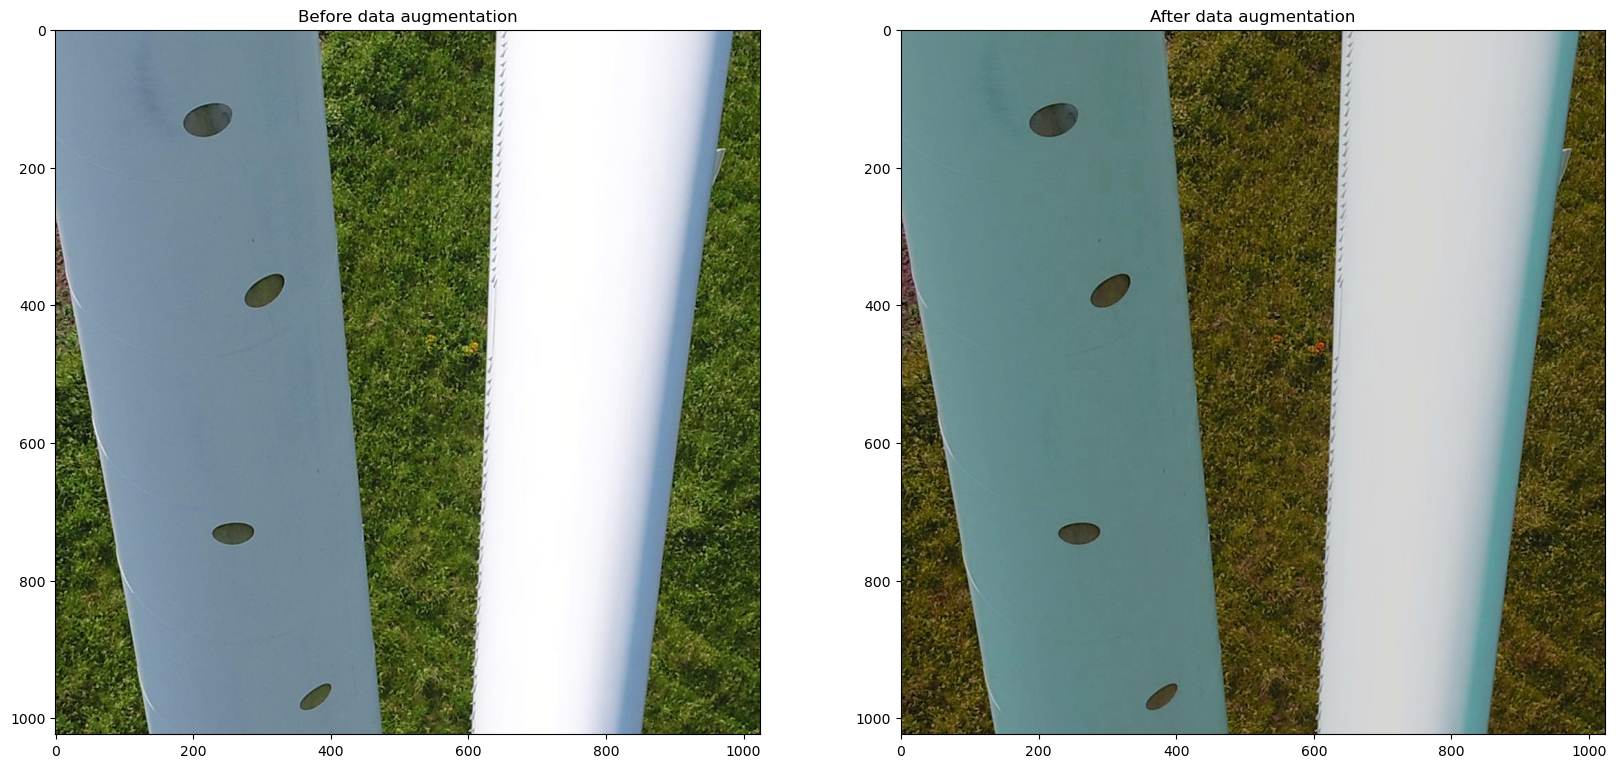

In [16]:
BeforeAfterDataAugmentation(TrainDatasetAugmented_zero, TrainDatasetOriginal_zero, 10)

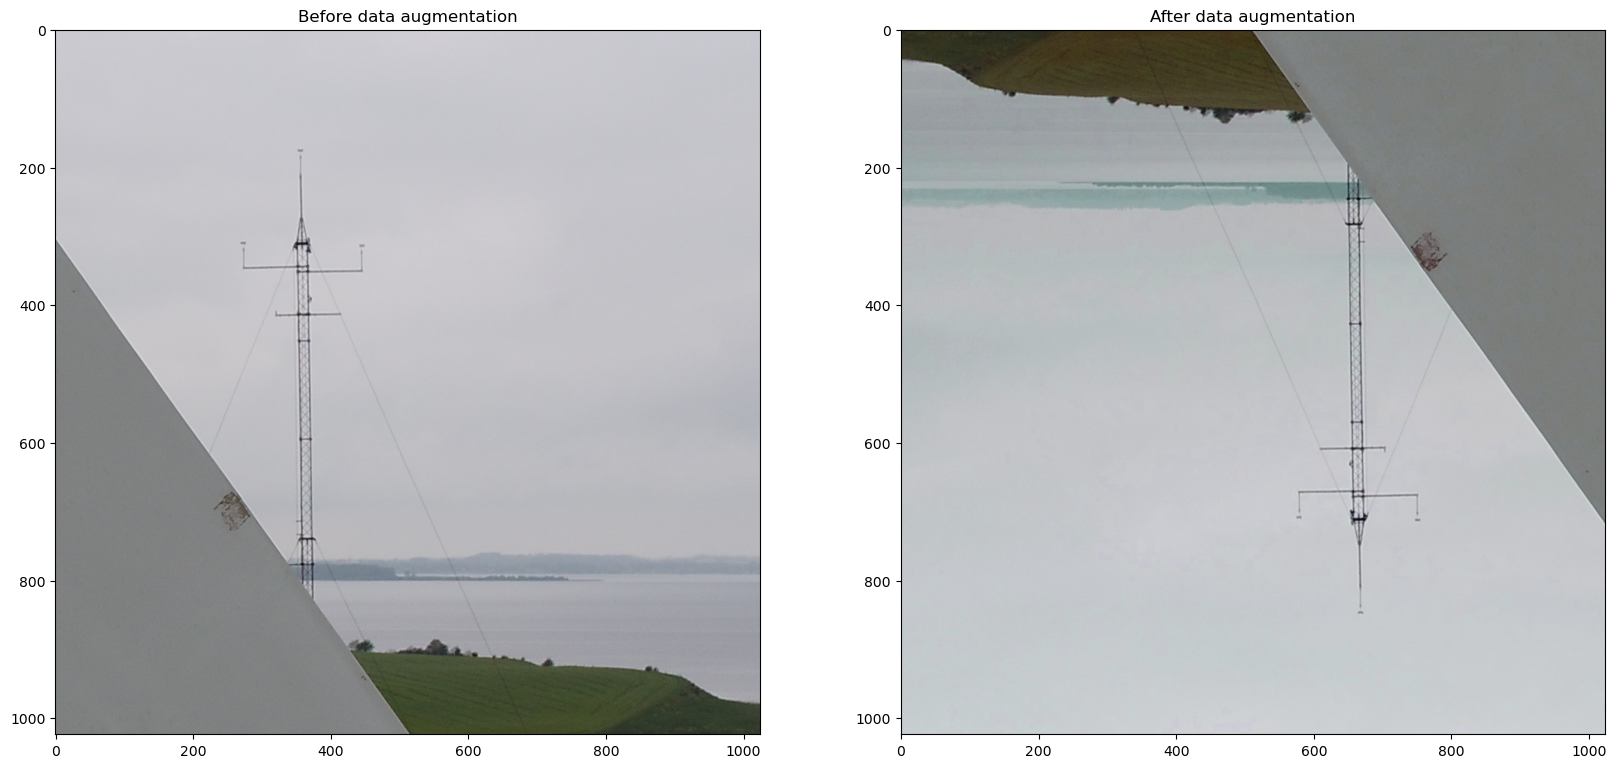

In [17]:
BeforeAfterDataAugmentation(TrainDatasetAugmented_one, TrainDatasetOriginal_one, 10)

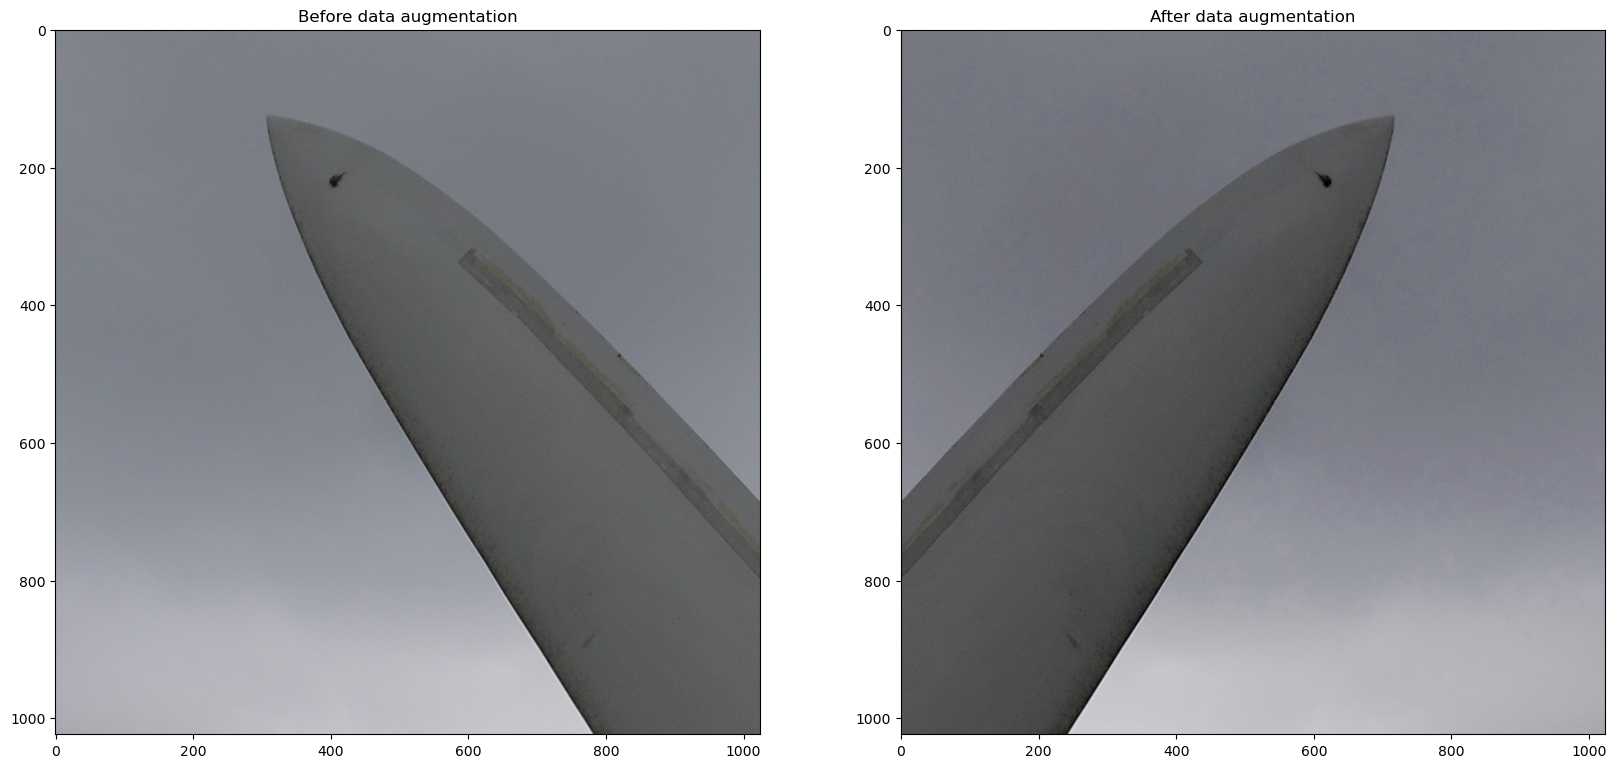

In [18]:
BeforeAfterDataAugmentation(TrainDatasetAugmented_two, TrainDatasetOriginal_two, 10)

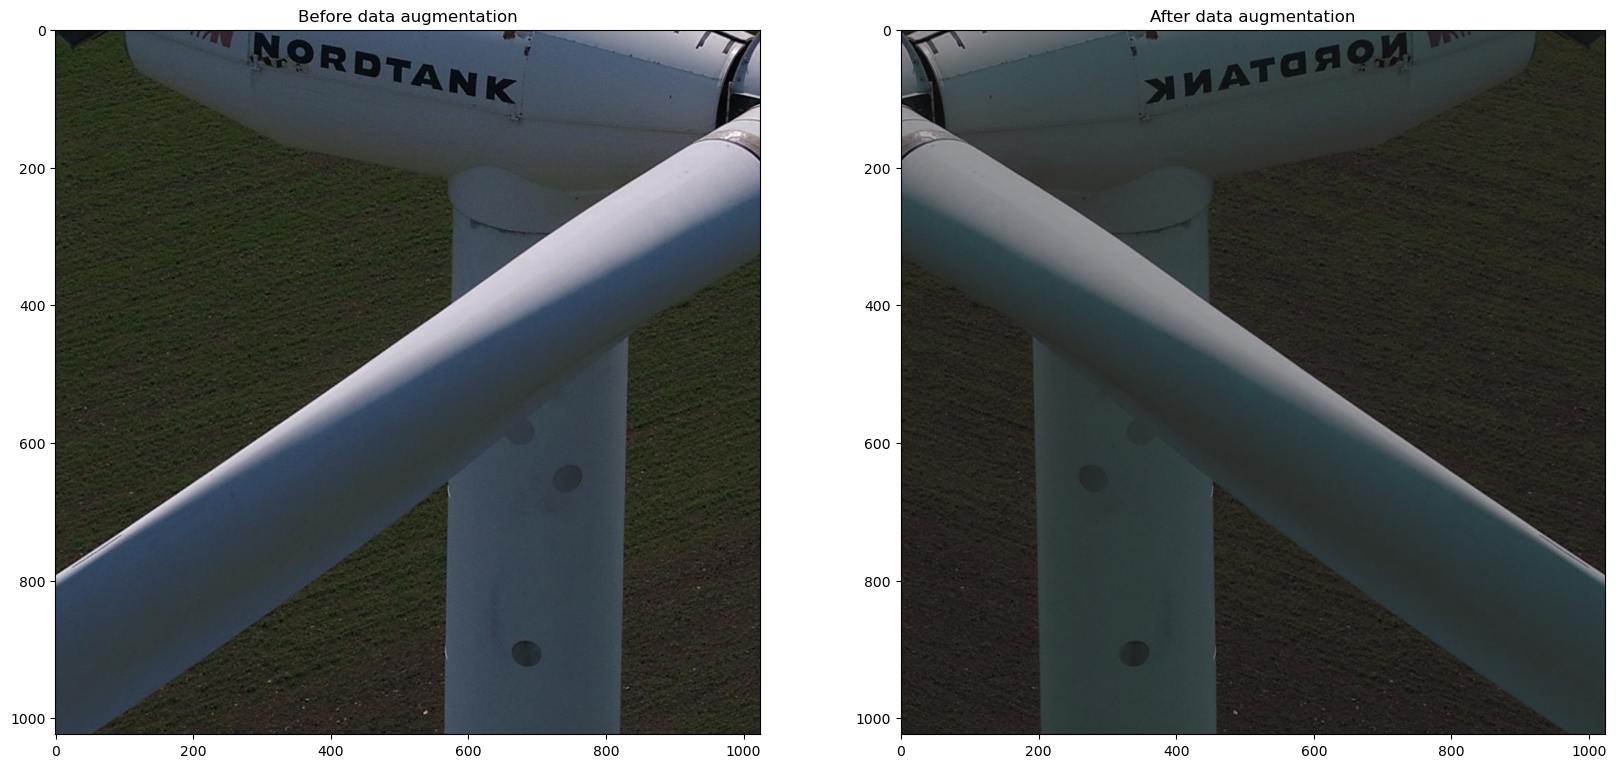

In [19]:
BeforeAfterDataAugmentation(TrainDatasetAugmented_three, TrainDatasetOriginal_three, 10)

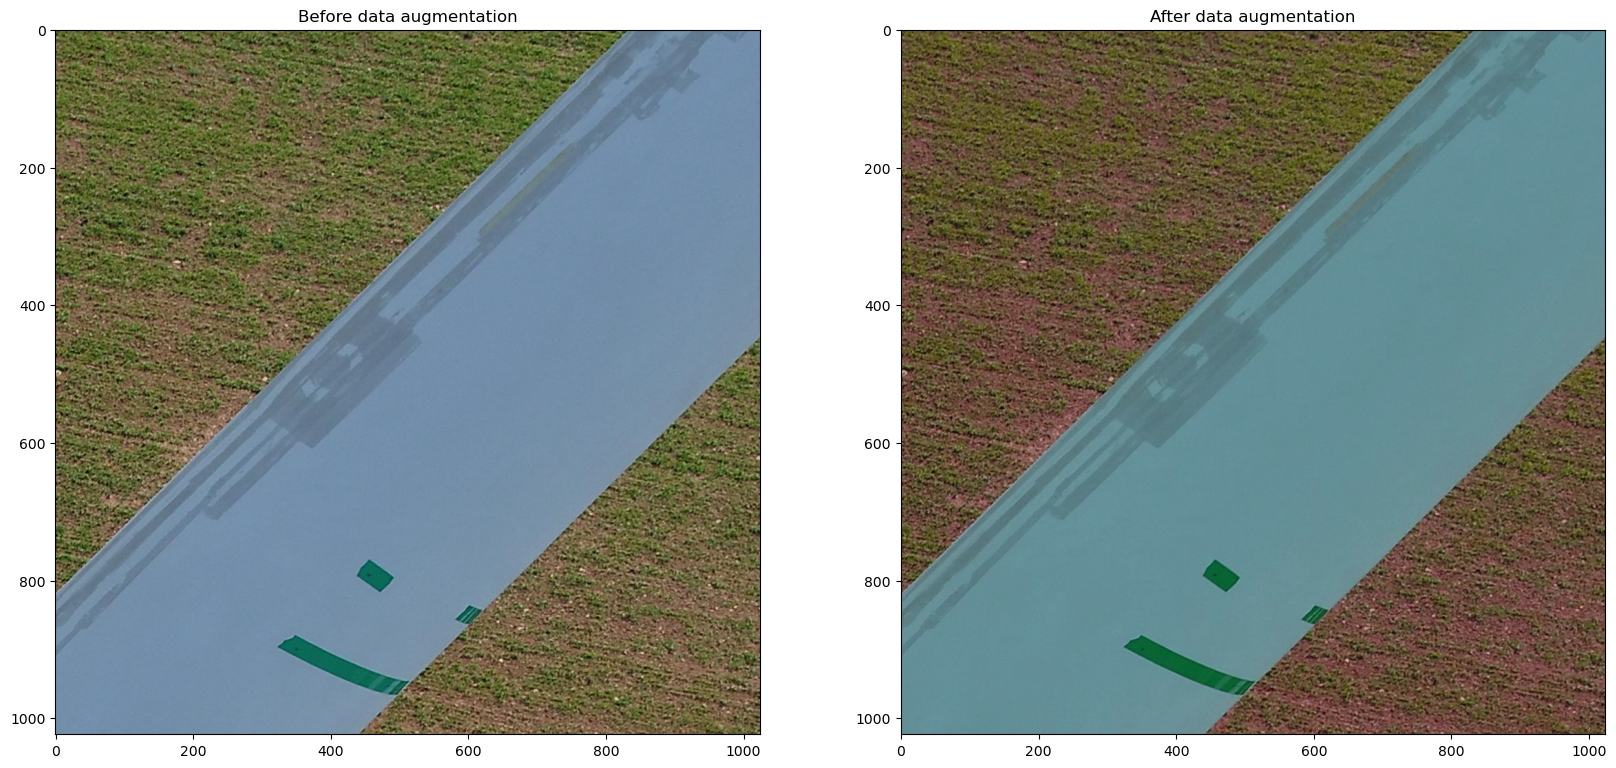

In [20]:
BeforeAfterDataAugmentation(TrainDatasetAugmented_four, TrainDatasetOriginal_four, 10)

## CNN

In [21]:
# Use DataLoader to handle batching and shuffling
batch_size = 128
TrainDatasetLoader = DataLoader(TrainDataset, batch_size = batch_size, shuffle = True)